# **Tutorial for cell-cell communication prediction for single-ST data with DeepTalk**

The notebook introduces to predicting cell-cell comunication using the DeepTalk method.

The notebook uses data from mouse brain cortex.).

## **Installation**
Make sure ```DeepTalk_ST``` is installed via ```pip install DeepTalk_ST```.

The Python environment needs to install the packages listed in ```environment.yml```.

In [1]:
import sys
import os
import random
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import json
import seaborn as sns
import copy
from orderedset import OrderedSet
import DeepTalk_ST as dt

%reload_ext autoreload
%autoreload 2
%matplotlib inline

## **Create a work folder and Download the data**

The MERFISH_genes.csv, st_flie.txt, st_location.txt, single_cell_process.R, geneinfo.rda,pathways.rda, lrpairs_new.csv, df_pathways.csv can be downloaded from https://github.com/JiangBioLab/DeepTalk/tree/main/test.

In [2]:
Test_dir = './test/single-cell/'
isExists = os.path.exists(Test_dir)
if isExists:
    pass
else:
    os.makedirs(Test_dir)

In [3]:
'''
# Skip this cells if data are already downloaded
!wget http://jianglab.org.cn/deeptalk_download/visp_sn_tpm_small_0430.rar -O ./Test1/single-cell/visp_sn_tpm_small_0430.rar
!tar -xf visp_sn_tpm_small_0430.rar -C Test_dir
'''

'\n# Skip this cells if data are already downloaded\n!wget http://jianglab.org.cn/deeptalk_download/visp_sn_tpm_small_0430.rar -O ./Test1/single-cell/visp_sn_tpm_small_0430.rar\n!tar -xf visp_sn_tpm_small_0430.rar -C Test_dir\n'

## **Load spatial data**
Spatial data need to be organized as a voxel-by-gene matrix. Here, MERFISH data contains 2,399 spatial voxels, in each of which there are 268 genes measured.

In [4]:
random.seed(1000)
ad_st = sc.read_csv(Test_dir + "/st_flie.txt", delimiter='\t', first_column_names=True)
ad_st

AnnData object with n_obs × n_vars = 2399 × 268

In [5]:
ad_st_raw = copy.deepcopy(ad_st)
#ad_st_raw = ad_st
sc.pp.normalize_total(ad_st)
#ad_st_raw1 = copy.deepcopy(ad_st)
#sc.pp.normalize_per_cell(ad_st, counts_per_cell_after=1e4)
sc.pp.log1p(ad_st)

In [6]:
st_spatial = np.loadtxt(Test_dir + "/st_location.txt",dtype=str, delimiter=' ')
st_spatial = st_spatial.astype(np.float64)

In [7]:
ad_st.obs['x'] = st_spatial[:,0]
ad_st.obs['y'] = st_spatial[:,1]
ad_st.obsm["spatial"]=st_spatial
ad_st_raw.obsm["spatial"]=st_spatial

In [8]:
ad_st.obs.copy()

,x,y
0,1161.113371,6178.383054
1,1162.913371,6113.133054
2,1168.313371,6046.083054
3,1163.813371,6202.683054
4,1166.963371,6083.883054
...,...,...
2394,3144.263371,5201.433054
2395,3154.613371,5331.033054
2396,3165.413371,5190.183054
2397,3189.713371,5292.783054


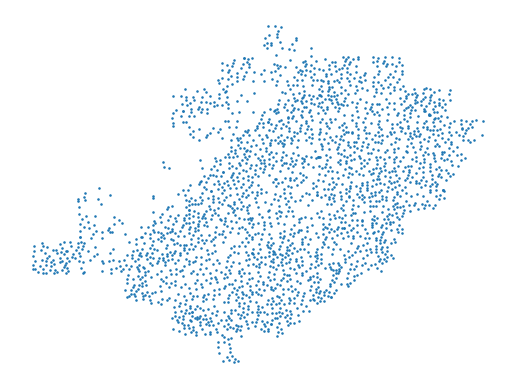

In [9]:
xs = ad_st.obs.x.values
ys = ad_st.obs.y.values
plt.axis('off')
plt.scatter(xs, ys, s=.7);
plt.gca().invert_yaxis()

## **Single cell data**
By single cell data, we generally mean either scRNAseq or snRNAseq.
They are 11,759 SMART-Seq2 snRNA-seq data from the VISp region.

In [10]:
path = os.path.join(Test_dir + "/visp_sn_tpm_small_0430.h5ad")
ad_sc = sc.read_h5ad(path)

In [11]:
ad_sc_raw0 = copy.deepcopy(ad_sc)
sc.pp.normalize_total(ad_sc)
#sc.pp.normalize_per_cell(ad_sc, counts_per_cell_after=1e4)
ad_sc_raw1 = copy.deepcopy(ad_sc)
sc.pp.log1p(ad_sc)
ad_sc_raw = copy.deepcopy(ad_sc)
sc.pp.highly_variable_genes(ad_sc, min_mean=0.0125, max_mean=4, min_disp=0.25)
sc.pp.scale(ad_sc, max_value=10)
ad_sc_raw2 = copy.deepcopy(ad_sc)
sc.pp.pca(ad_sc)
sc.pp.neighbors(ad_sc)
sc.tl.umap(ad_sc)
ad_sc

AnnData object with n_obs × n_vars = 11759 × 40056
    obs: 'consensus_cluster', 'reference_cluster', 'reference_color', 'broad_class', 'subclass', 'merged_cluster_smFISH', 'merged_cluster_ISS', 'total_reads', 'cpm_scaling_factor', 'n_genes'
    var: 'length', 'maxMeanFpkm', 'in_MERFISH', 'gene_id', 'chromosome', 'gene_entrez_id', 'gene_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [12]:
ad_sc_raw.obsm['X_umap']=ad_sc.obsm['X_umap']

## **Prepare to integration**

In [13]:
df_genes = pd.read_csv(Test_dir + '/MERFISH_genes.csv',header=None)
markers = np.reshape(df_genes.values[:,-1], (-1, ))
markers = list(markers)
len(markers)

254

In [14]:
dt.pp_adatas(ad_sc_raw, ad_st, genes=markers)

INFO:root:253 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:257 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


## **Integration sc/snRNA-seq and ST data**

In [15]:
ad_map = dt.map_cells_to_space(
    adata_sc=ad_sc_raw,
    adata_sp=ad_st,
    learning_rate=0.0001,
    num_epochs=3000,
    device='cuda:0',
)

Start training
Epoch 100, Loss: -0.531,Score0: 0.531,Time: 0.101
Epoch 200, Loss: -0.564,Score0: 0.564,Time: 0.102
Epoch 300, Loss: -0.589,Score0: 0.589,Time: 0.102
Epoch 400, Loss: -0.609,Score0: 0.609,Time: 0.099
Epoch 500, Loss: -0.624,Score0: 0.624,Time: 0.125
Epoch 600, Loss: -0.636,Score0: 0.636,Time: 0.105
Epoch 700, Loss: -0.645,Score0: 0.645,Time: 0.102
Epoch 800, Loss: -0.653,Score0: 0.653,Time: 0.101
Epoch 900, Loss: -0.659,Score0: 0.659,Time: 0.102
Epoch 1000, Loss: -0.665,Score0: 0.665,Time: 0.102
Epoch 1100, Loss: -0.670,Score0: 0.670,Time: 0.102
Epoch 1200, Loss: -0.675,Score0: 0.675,Time: 0.101
Epoch 1300, Loss: -0.679,Score0: 0.679,Time: 0.102
Epoch 1400, Loss: -0.683,Score0: 0.683,Time: 0.103
Epoch 1500, Loss: -0.687,Score0: 0.687,Time: 0.100
Epoch 1600, Loss: -0.691,Score0: 0.691,Time: 0.103
Epoch 1700, Loss: -0.694,Score0: 0.694,Time: 0.101
Epoch 1800, Loss: -0.697,Score0: 0.697,Time: 0.103
Epoch 1900, Loss: -0.700,Score0: 0.700,Time: 0.103
Epoch 2000, Loss: -0.703,

In [16]:
import torch
torch.cuda.empty_cache()

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


<Figure size 640x480 with 0 Axes>

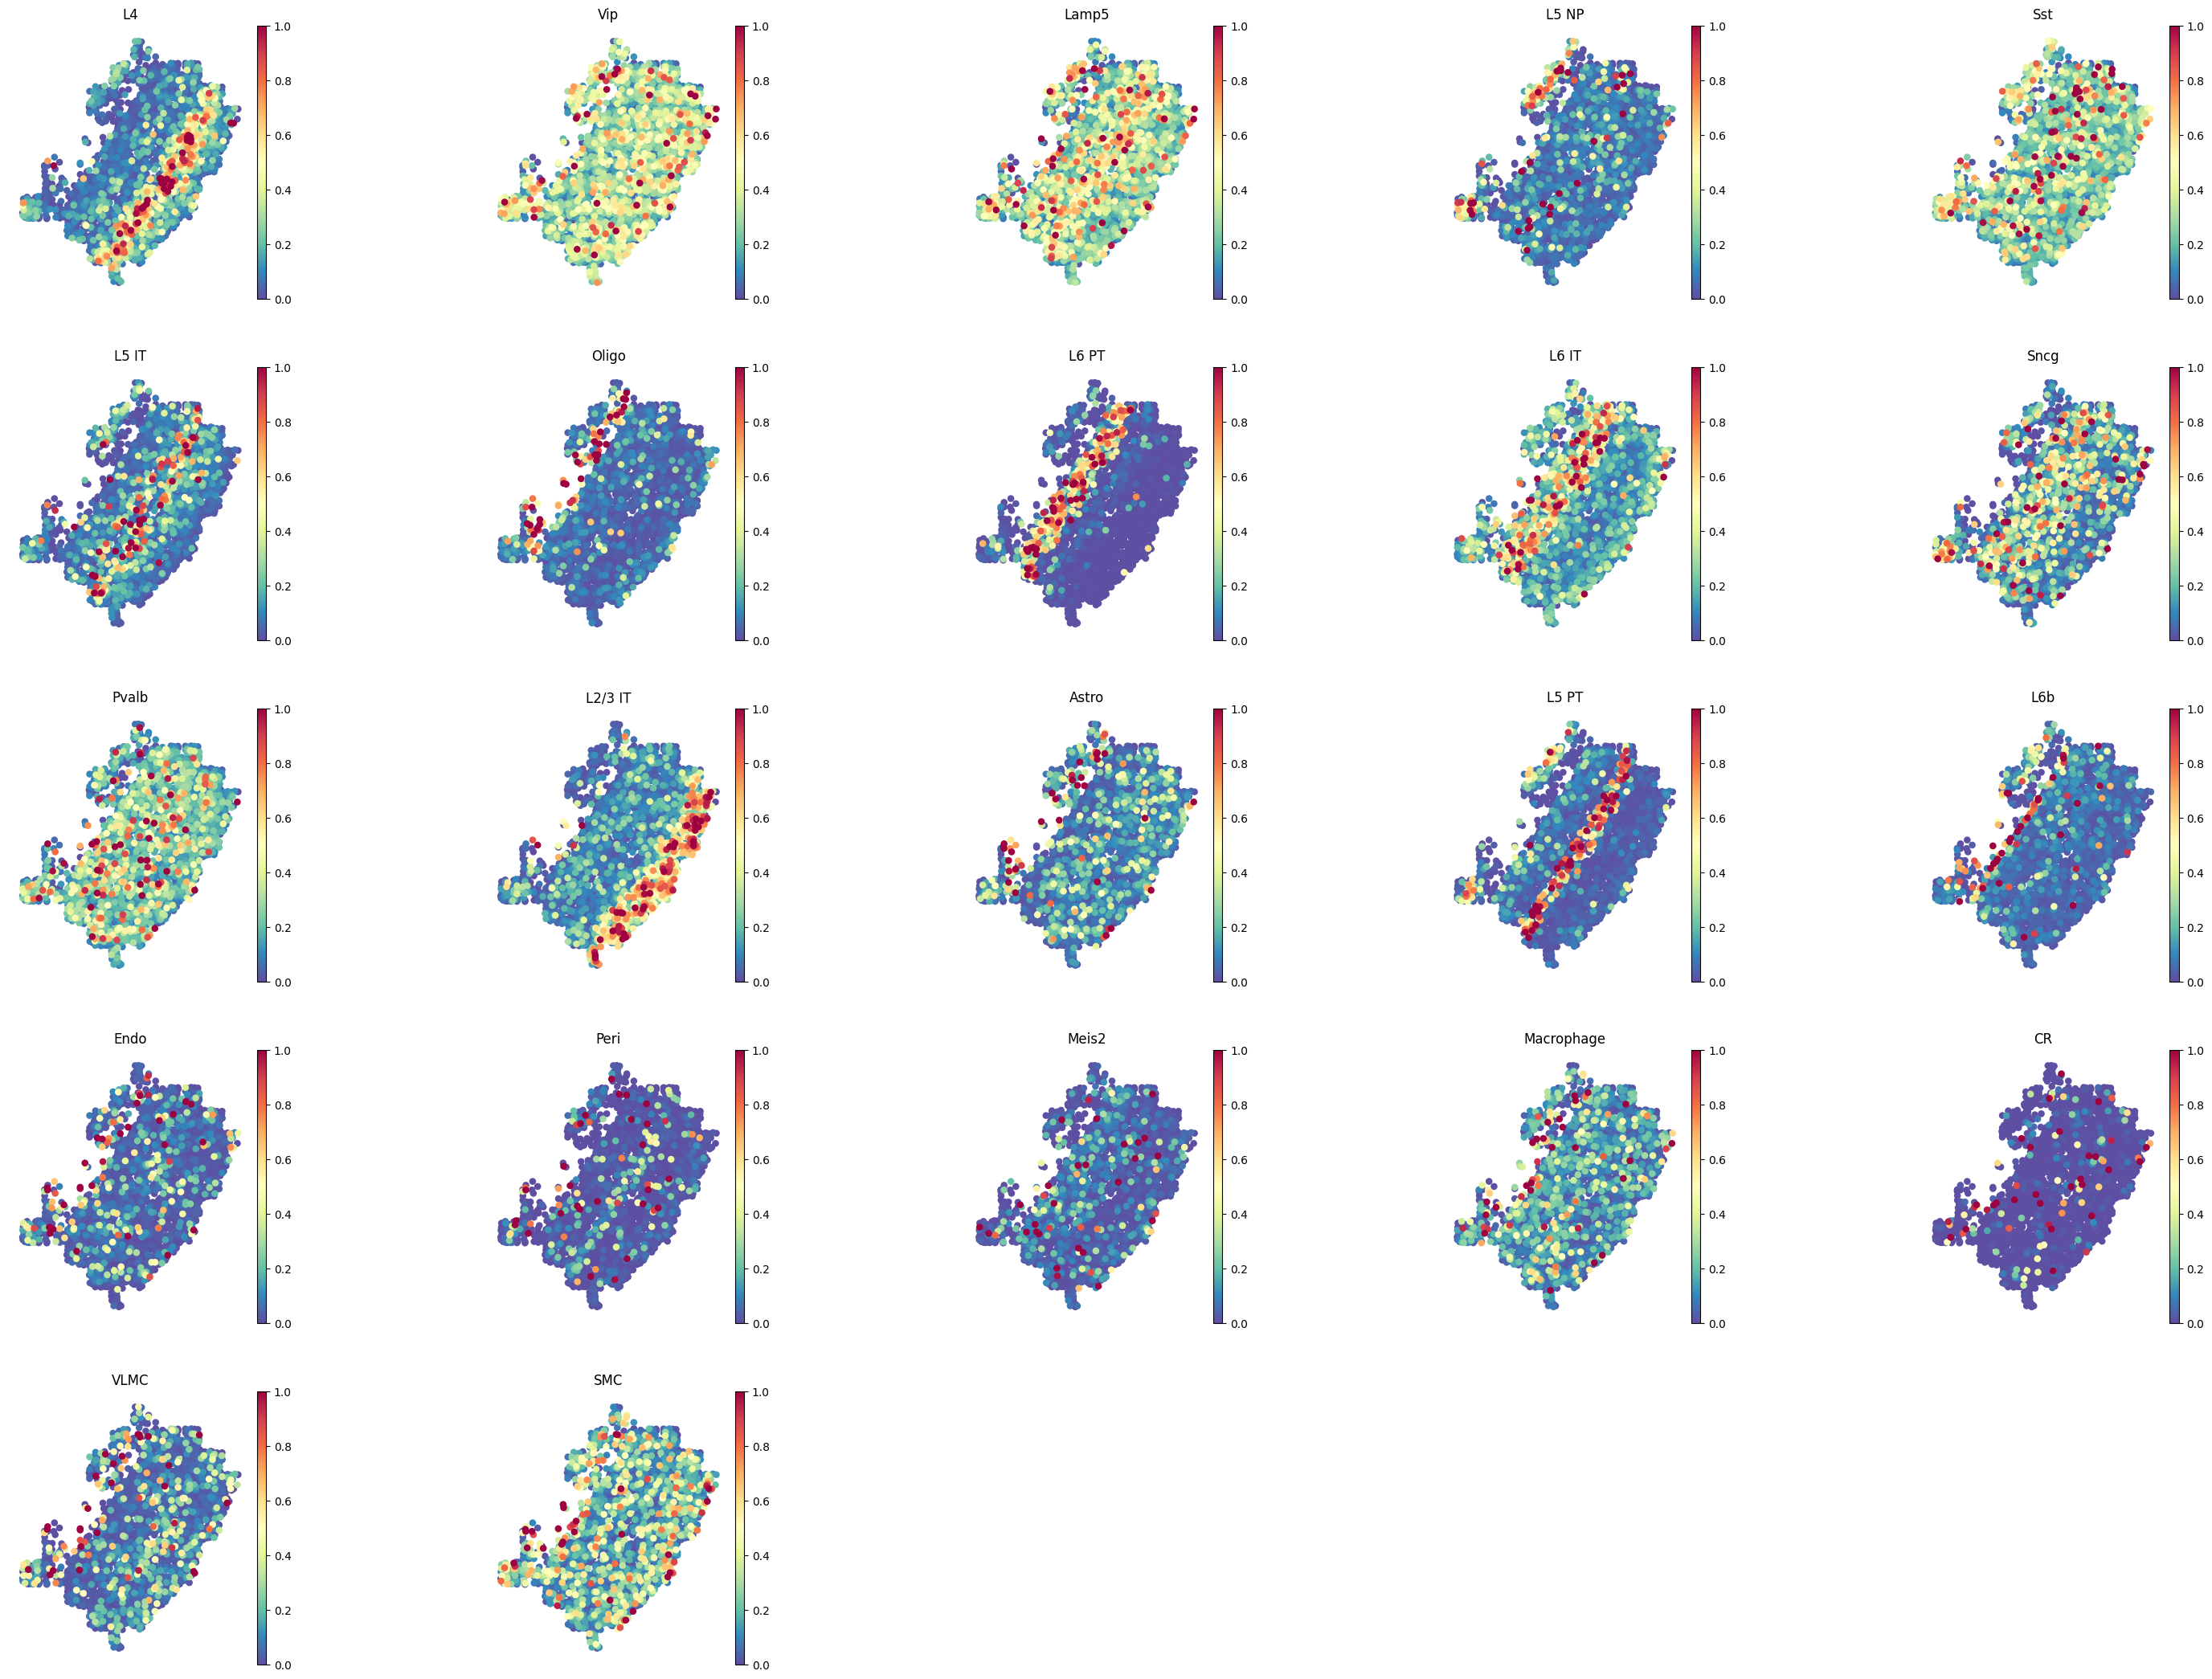

In [17]:
dt.project_cell_annotations(ad_map, ad_st, annotation="subclass")
annotation_list = list(pd.unique(ad_sc_raw.obs['subclass']))
dt.plot_cell_annotation_sc1(ad_st, annotation_list,spot_size=65, ncols=5,cmap='Spectral_r', scale_factor=0.1,perc=0.01)

## **Prepare to inference of cell-cell communication**

In [18]:
gene_all_mouse, gene_all_human = dt.gene_select(lrpairs = Test_dir + '/lrpairs_new.csv',TF = Test_dir + '/df_pathways.csv')

In [19]:
ad_ge = dt.project_genes(adata_map=ad_map, adata_sc=ad_sc_raw)
ad_ge

AnnData object with n_obs × n_vars = 2399 × 40056
    obs: 'x', 'y', 'uniform_density', 'rna_count_based_density'
    var: 'length', 'maxMeanFpkm', 'in_MERFISH', 'gene_id', 'chromosome', 'gene_entrez_id', 'gene_name', 'n_cells', 'sparsity', 'is_training'
    uns: 'log1p', 'training_genes', 'overlap_genes'

In [20]:
sc.pp.filter_cells(ad_ge, min_genes=200)
sc.pp.filter_genes(ad_ge, min_cells=3)
sc.pp.filter_genes_dispersion(ad_ge, flavor='cell_ranger', log=False)
ad_ge = ad_ge[:, ad_ge.X.mean(axis=0) >= 0.1]
ad_ge

View of AnnData object with n_obs × n_vars = 2399 × 2054
    obs: 'x', 'y', 'uniform_density', 'rna_count_based_density', 'n_genes'
    var: 'length', 'maxMeanFpkm', 'in_MERFISH', 'gene_id', 'chromosome', 'gene_entrez_id', 'gene_name', 'n_cells', 'sparsity', 'is_training', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'training_genes', 'overlap_genes'

## **Prepare to inference of cell-cell communication**

In [21]:
index1 = [word.capitalize() for word in ad_ge.var.index]
c_list = [f'C{i}' for i in range(1, ad_ge.X.shape[0]+1)]
st_data = pd.DataFrame(ad_ge.X.T,index=index1,columns=c_list)
st_data = st_data[st_data.index.isin(gene_all_mouse)]
#st_data.to_csv(Test_dir + '/ad_st_test.csv')
#df.to_csv(Test_dir + '/ad_st_test.csv',float_format='%.2f')
st_data

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C2390,C2391,C2392,C2393,C2394,C2395,C2396,C2397,C2398,C2399
Abhd6,0.136534,0.238503,0.158358,0.159525,0.252524,0.216274,0.235074,0.134509,0.235650,0.268522,...,0.339030,0.428744,0.308366,0.382683,0.338412,0.273236,0.558392,0.289088,0.755900,0.388304
Abr,0.070906,0.133968,0.090055,0.084502,0.163082,0.128826,0.147275,0.076055,0.133177,0.168307,...,0.189815,0.269225,0.165521,0.206554,0.179716,0.136289,0.284272,0.154143,0.436326,0.148093
Acaa1a,0.114784,0.169425,0.132643,0.103946,0.180927,0.186246,0.193122,0.105142,0.199833,0.326475,...,0.200863,0.513724,0.194306,0.220149,0.216569,0.160659,0.338615,0.172999,0.459891,0.285346
Acat1,0.202953,0.339502,0.176471,0.239302,0.361092,0.355222,0.283229,0.236726,0.340061,0.496506,...,0.397855,0.776927,0.358044,0.455472,0.375585,0.286376,0.624673,0.366727,1.007414,0.431763
Acot13,0.899114,1.352059,0.740194,0.932849,1.484623,1.349386,1.109248,0.978267,1.400847,1.972940,...,1.541331,2.404494,1.478487,1.718154,1.558157,1.157940,1.861925,1.495005,4.119618,2.356818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ywhae,1.169585,1.943296,1.033325,1.298453,2.290715,1.942811,1.505111,1.431659,1.899835,2.757700,...,2.529102,3.744747,2.194834,2.297894,2.433799,1.851524,3.497677,2.188877,4.551717,2.788484
Ywhag,0.211280,0.367416,0.220161,0.241017,0.424399,0.363539,0.273499,0.290180,0.354416,0.595691,...,0.415592,0.658283,0.376787,0.423994,0.399186,0.310358,0.662790,0.399825,0.945955,0.526449
Ywhah,1.396710,3.131638,1.170764,1.852172,3.512061,2.883662,2.207651,2.119653,2.584759,3.668597,...,3.996924,5.517158,3.198313,3.002386,3.538954,3.060849,5.138676,3.116289,5.134889,3.006065
Ywhaq,0.480318,0.781924,0.455595,0.525694,0.955133,0.834706,0.582403,0.527716,0.772186,1.239245,...,1.046655,1.444070,0.874592,1.015546,0.964819,0.730803,1.656042,0.890667,1.773757,1.190742


## **Generate training dataset and prediction dataset.**
Using the example of intercellular communication mediated by ```Sst-Sstr2``` and ```Apoe-Grm5```, train using ```Sst-Sstr2``` and predict intercellular communication mediated by ```Apoe-Grm5```.

In [22]:
pathways = Test_dir + "/pathways.csv"
species = "Mouse"
newmeta = ad_st.obs.copy()
newmeta.insert(0, 'cell', newmeta.index)
newmeta["cell"] = newmeta["cell"].astype(int) + 1
newmeta["cell"] = "C" + newmeta["cell"].astype(str)
st_coef = newmeta.iloc[:, 5:]
cellname = st_coef.columns
newmeta["celltype"] = ""
for i in range(st_coef.shape[0]):
    st_coef1 = st_coef.iloc[i, :]
    newmeta.iloc[i, newmeta.columns.get_loc('celltype')] = st_coef1.idxmax()
meta_data = newmeta[['cell', 'x', 'y', 'celltype']]
meta_data

,cell,x,y,celltype
0,C1,1161.113371,6178.383054,Vip
1,C2,1162.913371,6113.133054,L5 NP
2,C3,1168.313371,6046.083054,VLMC
3,C4,1163.813371,6202.683054,SMC
4,C5,1166.963371,6083.883054,Meis2
...,...,...,...,...
2394,C2395,3144.263371,5201.433054,L2/3 IT
2395,C2396,3154.613371,5331.033054,L4
2396,C2397,3165.413371,5190.183054,Sncg
2397,C2398,3189.713371,5292.783054,Vip


In [23]:
mapping_colors = {
    "L6 CT": (0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
    "L6 IT": (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
    "L5/6 NP": (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
    "L6b": "#0000c2ff",
    "L2/3 IT": "#a1ed7bff",
    "L5 IT": (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
    "L5 ET": (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
    "Oligo": (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
    "Vip": (0.6196078431372549, 0.6039215686274509, 0.7843137254901961),
    "Astro": "#ffdd55ff",
    "Micro-PVM": "#000000ff",
    "Pvalb": (0.38823529411764707, 0.38823529411764707, 0.38823529411764707),
    "Lamp5": (0.5882352941176471, 0.5882352941176471, 0.5882352941176471),
    "Sst": (0.7411764705882353, 0.7411764705882353, 0.7411764705882353),
    "Sst Chodl": (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
    "Sncg": (0.5176470588235295, 0.23529411764705882, 0.2235294117647059),
    "Peri": (0.6784313725490196, 0.28627450980392155, 0.2901960784313726),
    "VLMC": (0.8392156862745098, 0.3803921568627451, 0.4196078431372549),
    "Endo": (0.9058823529411765, 0.5882352941176471, 0.611764705882353),
    "Meis2": "#FFA500ff",
    "SMC": "#000000ff",
    "L6 PT": "#4682B4ff",
    "L5 PT": (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
    "L5 NP": "#6B8E23ff",
    "L4": "#d61f1dff",
    "Macrophage": "#2b2d2fff",
    "CR": "#000000ff",
}

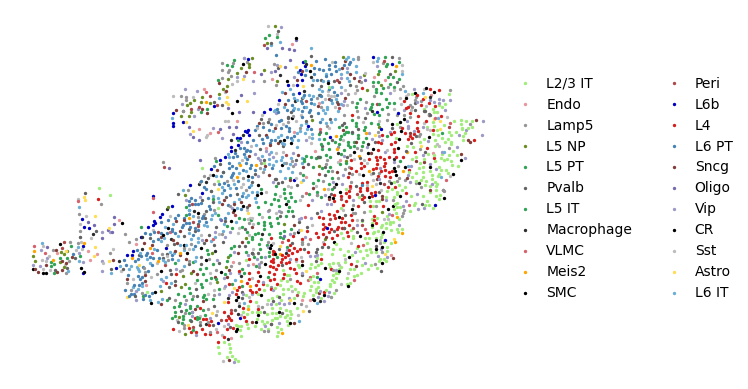

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
cluster = meta_data['celltype'].values
dt.plot_cell_type_ST(ad_st,mapping_colors,cluster)

## **Prediction of spatial CCC at the single-cell resolution.**
Train the data using subgraph-based GAT and generate a prediction model.

The trained model can be used to predict intercellular communication mediated by other L-R interactions.

In [25]:
lrpairs_train = {
    'ligand': ['Sst'],
    'receptor': ['Sstr2'],
    'species': ['Mouse']
}

lrpairs_train = pd.DataFrame(lrpairs_train)
lrpairs_train

,ligand,receptor,species
0,Sst,Sstr2,Mouse


In [26]:
dt.File_Train(st_data, pathways, lrpairs_train, meta_data, species, LR_train = 'Sst_Sstr2',
              outdir =  Test_dir)

Execution time: 386.74277663230896 seconds


In [27]:
dt.data_for_train(st_data, data_dir = Test_dir +'/data/',
	LR_train = 'Sst_Sstr2')

**The training process may take some time. You can download trained models from github.**


In [28]:
dt.Train(data_name = 'Sst_Sstr2',data_path = Test_dir + '/data/',
    outdir = Test_dir + '/data/Sst_Sstr2/output',
    pretrained_embeddings = Test_dir + '/data/Sst_Sstr2/data_pca.emd',
    n_epochs = 50,ft_n_epochs=10)


 Loading graph...
DataSet Stats :
Number of Nodes 2399
Number of Edges 118483
Number of Node types 1
Number of relations 1
Graph with 2399 nodes and 118483 edges
2399 2
check torch.Size([2399, 128]) 2399
node2vec tensor torch.Size([2399, 128])
No. of nodes with pretrained embedding:  2399
No. edges in test data:  47795
***************PRETRAINING***************

 generate walks ...
no. of walks 19192
train ./test/single-cell//data//Sst_Sstr2/outdir/Sst_Sstr2_walks_train.txt
validate ./test/single-cell//data//Sst_Sstr2/outdir/Sst_Sstr2_walks_validate.txt
test ./test/single-cell//data//Sst_Sstr2/outdir/Sst_Sstr2_walks_test.txt

 Run model for pre-training ...

 Begin Training

Epoch: 0
MinLoss: 1000000.0, CurLoss: 7.9147
epoch time: (s) 31.768967151641846

Epoch: 10
MinLoss: 1000000.0, CurLoss: 7.7889
epoch time: (s) 31.79668927192688

Epoch: 20
MinLoss: 1000000.0, CurLoss: 7.659
epoch time: (s) 30.42444944381714

Epoch: 30
MinLoss: 1000000.0, CurLoss: 7.2286
epoch time: (s) 30.925062179

**Predicting cell-cell communication mediated by ```Apoe-Grm5```.**

In [29]:
lrpairs_pre = {
    'ligand': ['Apoe'],
    'receptor': ['Grm5'],
    'species': ['Mouse']
}

lrpairs_pre = pd.DataFrame(lrpairs_pre)
lrpairs_pre

,ligand,receptor,species
0,Apoe,Grm5,Mouse


In [30]:
dt.File_Pre(st_data, pathways, lrpairs_pre, meta_data, species, LR_Pre = 'Apoe_Grm5',
              outdir =  Test_dir)

In [31]:
dt.data_for_pre(st_data, data_dir = Test_dir +'/data/',
	LR_pre = 'Apoe_Grm5')

In [34]:
dt.run_predict(data_name='Apoe_Grm5',data_path = Test_dir +'/data/',
    outdir = Test_dir +'/data/Apoe_Grm5/output',
    pretrained_embeddings = Test_dir +'/data/Apoe_Grm5/data_pca_pre.emd',
    model_path = Test_dir + '/data/Sst_Sstr2/output/finetune/results',
    best_id = 8, is_trained = True, model_name = Test_dir + '/Sst_Sstr2.model')

DataSet Stats :
Number of Nodes 2328
Number of Edges 111777
Number of Node types 1
Number of relations 1
check torch.Size([2328, 128]) 2261
node2vec tensor torch.Size([2328, 128])
4 4 Linear(in_features=512, out_features=512, bias=True)
Begin Predicting
Done


## **Visualize of the spatial CCC**


**Spatial distribution of cell types**

**Spatial cell-cell communication at single-cell resolution**

Show Top 50 communication score for predticted cell-cell communication

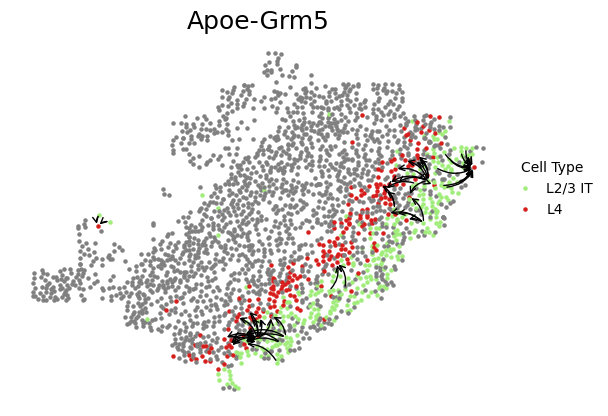

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
dt.plot_CCC_ST(ad_st, mapping_colors, cluster, st_data, ligand = 'Apoe',
    receptor = 'Grm5',CCC_label = Test_dir + '/data/Apoe_Grm5/predict_ccc.txt',
    sourcetype = 'L2/3 IT',targettype = 'L4',top_score = 50)

**Cell-cell communication between cell types**

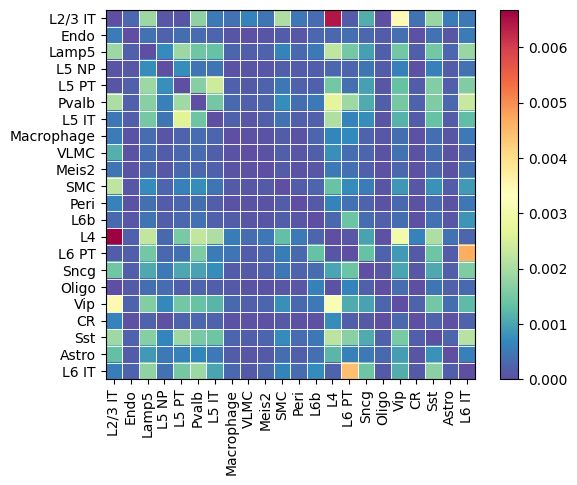

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
dt.plot_CCC_heatmap(cluster, st_data, ligand = 'Apoe', receptor = 'Grm5',
    CCC_label = Test_dir + '/data/Apoe_Grm5/predict_ccc.txt')